## Interacting Borehole Heat Exchangers in a Geothermal Setting


This example was originally published in Al-Khoury et al 2021. The original data was calculated using a finite element (FE) mesh and is used to test the MODFLOW 6 solution of a multi-source configuration of borehole heat exchangers.  Whereas the mesh used in Al-Khoury et al. (2021) calculates temperatures at FE mesh points, this setup uses those mesh points as vertices in a DISV grid.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
# Imports
import os
import pathlib as pl
import sys
from pprint import pformat

sys.path.append(os.path.join("..", "common"))

import math

import flopy
import git
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pooch
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwe-geotherm"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None

workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = root / "data" / sim_name if root else pl.Path.cwd()


# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Scenario-specific parameters.  Other scenarios are described in Al-Khoury et al 2021
parameters = {"ex-gwe-geotherm": {"dirichlet": 0.0, "neumann": 100.0}}

# Model Units
length_units = "meters"
time_units = "days"

# Model parameters
nper = 1  # Number of periods in flow model ($-$)
nlay = 1  # Number of layers ($-$)
simwid = 60  # Simulation width ($m$)
simlen = 90  # Simulation length ($m$)
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)
top = 1.0  # Top of the model ($m$)
botm = 0.0  # Bottom of the model ($m$)
prsity = 0.2  # Porosity ($-$)
perlen = 50  # Length of simulation ($days$)
strt_temp = 0.0  # Initial Temperature ($^{\circ}C$)
scheme = "TVD"  # Advection solution scheme ($-$)
ktw = 0.56  # Thermal conductivity of water ($\frac{W}{m \cdot ^{\circ}C}$)
kts = 2.50  # Thermal conductivity of aquifer material ($\frac{W}{m \cdot ^{\circ}C}$)
rhow = 1000  # Density of water ($kg/m^3$)
cpw = 4180.0  # Heat capacity of water ($\frac{J}{kg \cdot ^{\circ}C}$)
rhos = 2650.0  # Density of dry solid aquifer material ($kg/m^3$)
cps = 900.0  # Heat capacity of dry solid aquifer material ($\frac{J}{kg \cdot ^{\circ}C}$)
lhv = 2500.0  # Latent heat of vaporization ($\frac{J}{kg \cdot ^{\circ}C}$)
al = 0.0  # No mechanical dispersion ($m^2/day$)
ath1 = 0.0  # No transverse dispersivity ($m^2/day$)
strt = 1.00  # Starting head ($m$)

In [3]:
# ### Further refine parameters
laytyp = 1
nstp = 100
Lx = 90.0
v = 1e-5  # Groundwater seepage velocity ($m/s$)
q = v * 86400 * prsity
h1 = 1.001 + q * Lx  # Add one since that is the top elevation

icelltype = 0  # Cell conversion type (0: Cell thickness will be held constant)

# Convert Kts and Ktw units to use days
ktw = ktw * 86400
kts = kts * 86400

# Convert Watts (=J/sec) to J/days
unitadj = 86400

# Set up some global lists that will be set in the GWF setup but
# also needed in the GWE simulation
verts = []
cell2d = []
left_iverts = []
right_iverts = []
bore_iverts = []

# ### Solver Parameters

nouter = 1000
ninner = 100
hclose = 1e-9
rclose = 1e-6
relax = 1.0

### Model setup

Define functions to build models, write input files, and run the simulation.

In [4]:
# Static temporal data used by TDIS file Simulation has 1 steady stress period (1 day).
perlen = [perlen]
nstp = [1]
tsmult = [1.0]
tdis_ds = list(zip(perlen, nstp, tsmult))

# Lists to store the CV's that will be created for the left and right boundaries

left_iverts = []
right_iverts = []

# Functions for building the DISV mesh


# The original data by Al-Khoury et al. (2021) was for only half the mesh. The following function mirrors the mesh vertices about the x-axis
def mirror_mesh_pts(verts, idx_max):
    verts_mir = []
    vert_on_mir = []
    pairings = {}
    new_idx = idx_max - 1  # at this point, idx_max will be 1-based, new_idx is 0-based

    for itm in verts:
        if itm[2] == 0.0:
            # In this case, don't mirror a node that is on the axis about which
            # the mirror is being applied
            # However, log the vertex as one being on the mirror line
            vert_on_mir.append(int(itm[0]))

        else:
            new_idx += 1  # 0-based index
            verts_mir.append([new_idx, float(itm[1]), -1 * float(itm[2])])
            # Keep a dictionary of what goes with what for creating the new mirrored grid objects
            pairings.update({int(itm[0]): new_idx})

    return verts_mir, vert_on_mir, pairings


def mirror_mesh_ctrl_vols(iverts, full_verts, vert_on_mir, pairings):
    max_element_no = 0
    # start by determining the maximum element number
    for vert in iverts:
        element_id = vert[0]
        if element_id > max_element_no:
            max_element_no = element_id  # will be 0-based since they came in that way

    # create a "mirrored" control volume for every existing cv
    all_mirrored_ivert_collections = []
    idx = max_element_no
    for vert in iverts:
        # loop through every vertex surrounding current control volume to get list of corresponding element
        # (and maintain the order)
        cur_verts = vert[1:]
        corr_verts = []
        for v in cur_verts:
            if v in vert_on_mir:
                corr_verts.append(v)
            else:
                mir_vert = pairings[v]
                corr_verts.append(mir_vert)

        idx += 1
        new_cv = [idx] + corr_verts

        # before storing the new control volume, ensure number of vertices is the same
        assert len(vert) == len(new_cv), "Not enough vertices!"

        all_mirrored_ivert_collections.append(new_cv)

    # When finished with the above, add all_mirrored_ivert_collections to the original collection
    new_iverts = iverts + all_mirrored_ivert_collections

    return new_iverts


# In order to sort the vertices associated with the well-bore locations, need to calculate the angle from the center pt to sort them clockwise
def append_ang(bore_pts, x_base, y_base):
    # append the angle to each point in the list
    for pt in bore_pts:
        x = pt[1] - x_base
        y = pt[2] - y_base
        pt.append(math.atan2(x, y))

    return bore_pts


# The original mesh had holes where the bore locations are located. This function generates a control volume at the 9 borehole locations.
def add_9_ctrl_vols(verts_full, num_iverts_1based):
    num_iverts_0based = num_iverts_1based - 1
    thresh = 0.125

    # Initialize a dictionary of empty lists.
    boreX = {}
    for i in np.arange(9):
        boreX[i] = []

    # Locations of BHE are fixed for this example
    bore_locs = {
        0: [30, 5],
        1: [35, 5],
        2: [40, 5],
        3: [30, 0],
        4: [35, 0],
        5: [40, 0],
        6: [30, -5],
        7: [35, -5],
        8: [40, -5],
    }

    # Cycle through every vertex to see which borehole it may be associated
    # with (within 'thresh' distance)
    for vert in verts_full:
        x = float(vert[1])
        y = float(vert[2])

        for i in np.arange(9):
            x_dist = x - bore_locs[i][0]
            y_dist = y - bore_locs[i][1]

            if math.sqrt(x_dist**2 + y_dist**2) < thresh:
                boreX[i].append(vert)
                break

    # Each of the "boreX" lists needs to be sorted in clockwise order
    boreX_verts = []
    for i in np.arange(9):
        bore_dat = append_ang(boreX[i], bore_locs[i][0], bore_locs[i][1])
        bore_dat.sort(key=lambda x: x[3])
        # After sorting each bore, collect just the vertex IDs in their
        # sorted order
        num_iverts_0based += 1
        boreX_verts.append([num_iverts_0based] + [itm[0] for itm in boreX[i]])
        # Drop the angle off of the iverts in each boreX
        for itm in boreX[i]:
            itm.pop(-1)

    return boreX_verts


# Assess which vertices are located along the left and right boundaries
def determine_boundary_verts(verts_full):
    left_bnd_verts = []
    right_bnd_verts = []

    # The way to determine if a CV is on the left or right boundary is to check if it has a vertex on the boundary
    # The left boundary is at x=0, the right boundary is at x=90
    for vert in verts_full:
        vertex_x_coord = vert[1]
        if vertex_x_coord <= 0.0:
            left_bnd_verts.append(vert)
        elif vertex_x_coord >= 90.0:
            right_bnd_verts.append(vert)

    return left_bnd_verts, right_bnd_verts


# Add new vertices horizontally left or right of the boundary vertices for adding new constant head CV's to.
def create_bnd_iverts(bnd_verts, vert_idx, ivert_idx, side):
    new_bnd_verts = []
    new_bnd_iverts = []

    # convert the ivert_idx to 0-based
    ivert_idx -= 1

    # convert the vert_idx to 0-based
    vert_idx -= 1

    # Start by sorting the vertices top to bottom
    bnd_verts.sort(key=lambda x: x[2])

    # Once sorted, create rectangular iverts along entire boundary
    new_pt2 = None
    for i, (v1, v2) in enumerate(zip(bnd_verts[0:-1], bnd_verts[1:])):
        v_x_coord1 = v1[1]
        v_y_coord1 = v1[2]

        v_x_coord2 = v2[1]
        v_y_coord2 = v2[2]

        if i == 0:
            vert_idx += 1
            new_vert_no = vert_idx
            if side == "left":
                v_x_coord1_newpt = v_x_coord1 - 0.1
            elif side == "right":
                v_x_coord1_newpt = v_x_coord1 + 0.1

            v_y_coord1_newpt = v_y_coord1
            new_pt1 = [new_vert_no, v_x_coord1_newpt, v_y_coord1_newpt]
            new_bnd_verts.append(new_pt1)
        else:
            assert new_pt2 is not None
            new_pt1 = new_pt2

        vert_idx += 1
        if side == "left":
            v_x_coord2_newpt = v_x_coord2 - 0.1
        elif side == "right":
            v_x_coord2_newpt = v_x_coord2 + 0.1

        v_y_coord2_newpt = v_y_coord2
        new_pt2 = [vert_idx, v_x_coord2_newpt, v_y_coord2_newpt]
        new_bnd_verts.append(new_pt2)

        # Arrange the points to create a new ivert on the boundary
        ivert_idx += 1
        new_ivert_cv = [ivert_idx, v1[0], v2[0], new_pt2[0], new_pt1[0]]
        new_bnd_iverts.append(new_ivert_cv)

    return new_bnd_verts, new_bnd_iverts


# The first FOR loop reads the original data shared by Al-Khoury et al. (2021) and then the function further operates on that data using the function above
def read_finite_element_mesh(f):
    read_nodes = False
    verts = []
    max_idx = 0
    iverts = []
    with open(f) as foo:
        for line in foo:
            if line.startswith("'NODES'"):
                read_nodes = True
            elif line.startswith("'ELEMENTS'"):
                read_nodes = False
            elif read_nodes:
                t = line.strip().split()
                # assuming all verts/vert number combos are listed in an
                # assending order
                verts.append([int(t[0]) - 1, float(t[1]), float(t[2])])

                # If the max node number yet encountered, store it
                if int(t[0]) > max_idx:
                    max_idx = int(t[0])

            else:
                t = line.strip().split()
                rec = [int(t[0]) - 1] + [int(i) - 1 for i in t[2:]]

                iverts.append(rec)

    # Mirror about the y=0 line (the bottom of the grid)
    mirrored_verts, vert_on_mir, pairings = mirror_mesh_pts(verts, max_idx)
    iverts_full = mirror_mesh_ctrl_vols(iverts, mirrored_verts, vert_on_mir, pairings)

    # Make the full verts list
    verts_full = verts + mirrored_verts

    # At the 9 bore locations, need to fill them in with control volumes
    # To do this, need to figure out which verts are involved
    the_new_9 = add_9_ctrl_vols(verts_full, len(iverts_full))

    # Append the 9 new control volumes representative of the bore locations
    iverts_full = iverts_full + the_new_9

    # Return lists of vertices on the (1) left and (2) right model boundaries
    lverts, rverts = determine_boundary_verts(verts_full)

    # Create new CVs along the left and right boundaries that have a constant width
    # (for specifying boundary heads)
    for side, which_bnd_verts in zip(["left", "right"], [lverts, rverts]):
        new_bnd_verts, new_bnd_iverts = create_bnd_iverts(
            which_bnd_verts, len(verts_full), len(iverts_full), side
        )
        verts_full = verts_full + new_bnd_verts
        iverts_full = iverts_full + new_bnd_iverts
        if side == "left":
            left_iverts = new_bnd_iverts.copy()
        elif side == "right":
            right_iverts = new_bnd_iverts.copy()

    # Calculate cell center locations for each element
    # and store xyverts for later use.
    xc, yc = [], []
    xyverts = []
    for iv in iverts_full:
        xv, yv = [], []
        for v in iv[1:]:
            tiv, txv, tyv = verts_full[v]
            xv.append(txv)
            yv.append(tyv)

        xc.append(np.mean(xv))
        yc.append(np.mean(yv))
        xyverts.append(list(zip(xv, yv)))

    # Create a cell2d record
    cell2d = []
    for ix, iv in enumerate(iverts_full):
        xv, yv = np.array(xyverts[ix]).T
        if flopy.utils.geometry.is_clockwise(xv, yv):
            rec = [iv[0], xc[ix], yc[ix], len(iv[1:])] + iv[1:]
        else:
            iiv = iv[1:][::-1]
            rec = [iv[0], xc[ix], yc[ix], len(iiv)] + iiv

        cell2d.append(rec)

    return verts_full, cell2d, left_iverts, right_iverts, the_new_9


def build_mf6_flow_model(sim_name, silent=True):
    global verts, cell2d, left_iverts, right_iverts, bore_iverts
    global top, botm

    gwfname = "gwf-" + sim_name.split("-")[2]
    sim_ws = os.path.join(workspace, sim_name, "mf6gwf")

    # Instantiate a new MF6 simulation
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

    # Instantiating MODFLOW 6 time discretization
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file="{}.nam".format(gwfname),
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        complexity="COMPLEX",
        no_ptcrecord="all",
        linear_acceleration="bicgstab",
        scaling_method="NONE",
        reordering_method="NONE",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        under_relaxation="dbd",
        under_relaxation_theta=0.7,
        under_relaxation_kappa=0.08,
        under_relaxation_gamma=0.05,
        under_relaxation_momentum=0.0,
        backtracking_number=20,
        backtracking_tolerance=2.0,
        backtracking_reduction_factor=0.2,
        backtracking_residual_limit=5.0e-4,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        relaxation_factor=0.0,
        number_orthogonalizations=2,
        preconditioner_levels=8,
        preconditioner_drop_tolerance=0.001,
        rcloserecord="{} strict".format(rclose),
        filename="{}.ims".format(sim_name),
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    fname = "Mesh.dat"
    fpath = pooch.retrieve(
        url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/develop/data/{sim_name}/{fname}",
        fname=fname,
        path=data_path,
        known_hash="md5:f3d321b7690f9f1f7dcd730c2bfe8e23",
    )
    verts, cell2d, left_iverts, right_iverts, bore_iverts = read_finite_element_mesh(
        fpath
    )
    top = np.ones((len(cell2d),))
    botm = np.zeros((1, len(cell2d)))

    flopy.mf6.ModflowGwfdisv(
        gwf,
        length_units=length_units,
        nogrb=True,
        ncpl=len(cell2d),
        nvert=len(verts),
        nlay=nlay,
        top=top,
        botm=botm,
        idomain=1,
        vertices=verts,
        cell2d=cell2d,
        pname="DISV",
        filename="{}.disv".format(gwfname),
    )

    # Instantiating MODFLOW 6 node property flow package
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=icelltype,
        xt3doptions="XT3D",
        k=k11,
        save_specific_discharge=True,
        save_saturation=True,
        pname="NPF",
        filename="{}.npf".format(gwfname),
    )

    # Instatiating MODFLOW 6 initial conditions package
    flopy.mf6.ModflowGwfic(gwf, strt=strt)

    # Instantiating MODFLOW 6 storage package
    flopy.mf6.ModflowGwfsto(
        gwf, ss=0, sy=0, pname="STO", filename="{}.sto".format(gwfname)
    )

    # Instantiating 1st instance of MODFLOW 6  constant head package (left side)
    # (setting auxiliary temperature to 0.0)
    chd_spd = []
    chd_spd += [[0, i[0], h1, 0.0] for i in left_iverts]
    chd_spd = {0: chd_spd}
    flopy.mf6.ModflowGwfchd(
        gwf,
        auxiliary="TEMPERATURE",
        stress_period_data=chd_spd,
        pname="CHD-LEFT",
        filename="{}.left.chd".format(sim_name),
    )

    # Instantiating 2nd instance of MODFLOW 6 constant head package (right side)
    chd_spd = []
    chd_spd += [[0, i[0], 1.001, 0.0] for i in right_iverts]
    chd_spd = {0: chd_spd}
    flopy.mf6.ModflowGwfchd(
        gwf,
        auxiliary="TEMPERATURE",
        stress_period_data=chd_spd,
        pname="CHD-RIGHT",
        filename="{}.right.chd".format(sim_name),
    )

    # Instantiating MODFLOW 6 output control package (flow model)
    head_filerecord = "{}.hds".format(sim_name)
    budget_filerecord = "{}.cbc".format(sim_name)
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
        pname="OC",
    )

    return sim


def build_mf6_heat_model(sim_name, dirichlet=0.0, neumann=0.0, silent=False):
    print("Building mf6gwt model...{}".format(sim_name))
    gwename = "gwe-" + sim_name.split("-")[2]
    sim_ws = os.path.join(workspace, sim_name, "mf6gwe")

    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

    # Instantiating MODFLOW 6 groundwater transport model
    gwe = flopy.mf6.MFModel(
        sim,
        model_type="gwe6",
        modelname=gwename,
        model_nam_file="{}.nam".format(gwename),
    )

    # Create iterative model solution and register the gwe model with it
    imsgwe = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        complexity="SIMPLE",
        no_ptcrecord="all",
        linear_acceleration="bicgstab",
        scaling_method="NONE",
        reordering_method="NONE",
        outer_maximum=nouter,
        outer_dvclose=hclose * 1000,
        under_relaxation="dbd",
        under_relaxation_theta=0.7,
        under_relaxation_kappa=0.08,
        under_relaxation_gamma=0.05,
        under_relaxation_momentum=0.0,
        backtracking_number=20,
        backtracking_tolerance=2.0,
        backtracking_reduction_factor=0.2,
        backtracking_residual_limit=5.0e-4,
        inner_maximum=ninner,
        inner_dvclose=hclose * 1000,
        relaxation_factor=0.0,
        number_orthogonalizations=2,
        preconditioner_levels=8,
        preconditioner_drop_tolerance=0.001,
        rcloserecord="{} strict".format(rclose),
        filename="{}.ims".format(gwename),
    )
    sim.register_ims_package(imsgwe, [gwe.name])

    # MF6 time discretization differs from corresponding flow simulation
    tdis_rc = []
    for tm in np.arange(perlen[0]):
        if tm < 1:
            tdis_rc.append((1, 12, 1.3))
        elif tm <= 10:
            tdis_rc.append((1, 1, 1.0))
        else:
            tdis_rc.append((1, 1, 1.0))

    flopy.mf6.ModflowTdis(
        sim, nper=len(tdis_rc), perioddata=tdis_rc, time_units=time_units
    )

    # Instantiating MODFLOW 6 heat transport discretization package
    flopy.mf6.ModflowGwedisv(
        gwe,
        nlay=nlay,
        ncpl=len(cell2d),
        nvert=len(verts),
        top=top,
        botm=botm,
        idomain=1,
        vertices=verts,
        cell2d=cell2d,
        pname="DISV-GWE",
        filename="{}.disv".format(gwename),
    )

    # Instantiating MODFLOW 6 heat transport initial temperature
    flopy.mf6.ModflowGweic(gwe, strt=strt_temp, filename="{}.ic".format(gwename))

    # Instantiating MODFLOW 6 heat transport advection package
    flopy.mf6.ModflowGweadv(gwe, scheme=scheme, filename="{}.adv".format(gwename))

    # Instantiating MODFLOW 6 heat transport dispersion package
    if ktw != 0:
        flopy.mf6.ModflowGwecnd(
            gwe,
            alh=al,
            ath1=ath1,
            ktw=ktw,
            kts=kts,
            pname="CND",
            filename="{}.dsp".format(gwename),
        )

    # Instantiating MODFLOW 6 heat transport mass storage package (consider renaming to est)
    flopy.mf6.ModflowGweest(
        gwe,
        porosity=prsity,
        cps=cps,
        rhos=rhos,
        packagedata=[cpw, rhow, lhv],
        pname="EST",
        filename="{}.est".format(gwename),
    )

    # Instantiating MODFLOW 6 heat transport constant temperature package (Dirichlet case)
    if dirichlet > 0:
        ctpspd = {}
        for tm in np.arange(10):
            ctpspd_bore = []
            for bore_loc in bore_iverts:
                #              (layer,       CV ID, temperature)
                ctpspd_bore.append([0, bore_loc[0], float(tm + 1.0)])

            ctpspd.update({tm: ctpspd_bore})

        flopy.mf6.ModflowGwectp(
            gwe,
            maxbound=len(ctpspd),
            stress_period_data=ctpspd,
            save_flows=False,
            pname="CTP-1",
            filename="{}.ctp".format(gwename),
        )

    if neumann > 0:
        eslspd = {}
        for tm in np.arange(10):
            eslspd_bore = []
            for bore_loc in bore_iverts:
                #               layer,       CV ID,     Watts added)
                eslspd_bore.append([0, bore_loc[0], float((tm + 1) * 10.0 * unitadj)])

            eslspd.update({tm: eslspd_bore})

        flopy.mf6.ModflowGweesl(
            gwe,
            maxbound=len(eslspd),
            stress_period_data=eslspd,
            save_flows=False,
            pname="ESR-1",
            filename="{}.src".format(gwename),
        )

    # Instantiating MODFLOW 6 source/sink mixing package for dealing with
    # auxiliary temperature specified in constant head boundary package.
    sourcerecarray = [
        ("CHD-LEFT", "AUX", "TEMPERATURE"),
        ("CHD-RIGHT", "AUX", "TEMPERATURE"),
    ]
    flopy.mf6.ModflowGwessm(
        gwe, sources=sourcerecarray, filename="{}.ssm".format(gwename)
    )

    # Instantiating MODFLOW 6 heat transport output control package
    flopy.mf6.ModflowGweoc(
        gwe,
        budget_filerecord="{}.cbc".format(gwename),
        temperature_filerecord="{}.ucn".format(gwename),
        temperatureprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord={
            49: [("TEMPERATURE", "LAST"), ("BUDGET", "LAST")],
            50: [],  # Turn off output in stress periods 51-99
            99: [("TEMPERATURE", "LAST"), ("BUDGET", "LAST")],
        },
        printrecord=[("TEMPERATURE", "LAST"), ("BUDGET", "LAST")],
    )

    # Instantiating MODFLOW 6 Flow-Model Interface package
    pd = [
        ("GWFHEAD", "../mf6gwf/ex-" + gwename + ".hds", None),
        ("GWFBUDGET", "../mf6gwf/ex-" + gwename + ".cbc", None),
    ]
    flopy.mf6.ModflowGwefmi(gwe, packagedata=pd)

    return sim


def write_mf6_models(sim_mf6gwf, sim_mf6gwe, silent=True):
    sim_mf6gwf.write_simulation(silent=silent)
    sim_mf6gwe.write_simulation(silent=silent)


@timed
def run_model(sim, silent=True):
    success = True
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)

### Plotting results

Define functions to plot model results.

In [5]:
def plot_grid(sim):
    with styles.USGSPlot():
        simname = sim.name
        gwf = sim.get_model("gwf-" + simname.split("-")[2])

        figure_size = (6.5, 5)
        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        ax = fig.add_subplot(1, 1, 1, aspect="equal")

        # Create a Rectangle patch
        rect = patches.Rectangle(
            (28, -0.5),
            9,
            6,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
            zorder=3,
        )

        # Add the location of the inset plot to current plot
        ax.add_patch(rect)

        # plot up the cellid numbers with regard to
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
        pmv.plot_grid(lw=0.4)

        pmv.plot_bc(name="CHD-LEFT", alpha=0.75)
        pmv.plot_bc(name="CHD-RIGHT", alpha=0.75)
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")
        styles.heading(ax, heading=" DISV Grid", idx=0)

        # save figure
        if plot_show:
            plt.show()
        if plot_save:
            fpth = os.path.join(figs_path / "{}-grid{}".format(simname, ".png"))
            fig.savefig(fpth, dpi=300)


def plot_grid_inset(sim):
    with styles.USGSPlot():
        simname = sim.name
        gwf = sim.get_model("gwf-" + simname.split("-")[2])

        figure_size = (6, 4)
        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        ax = fig.add_subplot(1, 1, 1, aspect="equal")

        # plot up the cellid numbers with regard to
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
        pmv.plot_grid(lw=0.4)

        pmv.plot_bc(name="CHD-LEFT", alpha=0.75)
        pmv.plot_bc(name="CHD-RIGHT", alpha=0.75)
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")
        ax.set_xlim(28, 37)
        ax.set_ylim(-0.5, 5.5)
        styles.heading(ax, heading=" DISV Grid Inset", idx=1)

        # save figure
        if plot_show:
            plt.show()
        if plot_save:
            fpth = os.path.join(figs_path / "{}-grid-inset{}".format(simname, ".png"))
            fig.savefig(fpth, dpi=300)


def plot_head(sim):
    with styles.USGSPlot():
        figure_size = (6.5, 5)

        simname = sim.name
        gwf = sim.get_model("gwf-" + simname.split("-")[2])
        head = gwf.output.head().get_data()[:, 0, :]

        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)

        cb = pmv.plot_array(head, cmap="jet")
        cbar = plt.colorbar(cb, shrink=0.25)
        cbar.ax.set_xlabel(r"Head, ($m$)")
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")
        styles.heading(ax, heading="Simulated Head", idx=2)

        # save figure
        if plot_show:
            plt.show()
        if plot_save:
            fpth = os.path.join(figs_path / "{}-head{}".format(simname, ".png"))
            fig.savefig(fpth, dpi=300)


def plot_temperature(sim, scen, time_):
    figure_size = (6.5, 5)

    # Get analytical solution
    # aX_pth = os.path.join('..', 'data', 'ex-gwe-geotherm')
    fname = "spectral_Qin=100_t=50d-X.csv"
    aX_pth = pooch.retrieve(
        url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/develop/data/{sim_name}/{fname}",
        fname=fname,
        path=data_path,
        known_hash="md5:c6f08403c9863da315393ad9bf3f0f33",
    )
    aX = np.loadtxt(aX_pth, delimiter=",")

    fname = "spectral_Qin=100_t=50d-Y.csv"
    aY_pth = pooch.retrieve(
        url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/develop/data/{sim_name}/{fname}",
        fname=fname,
        path=data_path,
        known_hash="md5:8901f084096a8868b4d25393162fc780",
    )
    aY = np.loadtxt(aY_pth, delimiter=",")

    fname = "spectral_Qin=100_t=50d-Z.csv"
    aZ_pth = pooch.retrieve(
        url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/develop/data/{sim_name}/{fname}",
        fname=fname,
        path=data_path,
        known_hash="md5:c011c72c7e8af10e6bd2fcc5fb069884",
    )
    aZ = np.loadtxt(aZ_pth, delimiter=",")

    # X values need a shift relative to what Al-Khoury et al. (2021) shared
    Xnew = aX + 35.0

    simname = sim.name
    gwe = sim.get_model("gwe-" + simname.split("-")[2])

    with styles.USGSPlot():
        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        temp = (
            gwe.output.temperature().get_alldata()
        )  # eventually restore to: .temperature().
        if time_ == 50:  # first of two output times saved was at 50 days
            ct = 0
        elif time_ == 100:  # second of two output times saved was at 100 days
            ct = 1

        tempXXd = temp[ct]

        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwe, ax=ax, layer=0)

        levels = [1, 2, 3, 4, 6, 8]
        cmap = plt.cm.jet  # .plasma

        # extract discrete colors from the .plasma map
        cmaplist = [cmap(i) for i in np.linspace(0, 1, len(levels))]

        cs1 = pmv.contour_array(tempXXd, levels=levels, colors=cmaplist, linewidths=0.5)

        labels = ax.clabel(
            cs1,
            cs1.levels,
            inline=False,
            inline_spacing=0.0,
            fmt="%1d",
            fontsize=8,
        )
        cs2 = ax.contour(
            Xnew,
            aY,
            aZ,
            levels=levels,
            colors=cmaplist,
            linewidths=0.9,
            linestyles="dashed",
        )

        for label in labels:
            label.set_bbox(dict(facecolor="white", pad=1, ec="none"))

        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")
        ax.set_xlim([29, 50])
        ax.set_ylim([-8, 8])
        styles.heading(
            ax,
            heading=" Simulated Temperature at " + str(time_) + " days",
            idx=3,
        )

        # save figure
        if plot_show:
            plt.show()
        if plot_save:
            fpth = os.path.join(figs_path / "{}-temp50days{}".format(simname, ".png"))
            fig.savefig(fpth, dpi=300)


def plot_results(idx, sim_mf6gwf, sim_mf6gwe, silent=True):
    # Only need to plot the grid once, do it the first time through
    plot_grid(sim_mf6gwf)
    plot_grid_inset(sim_mf6gwf)
    plot_head(sim_mf6gwf)

    scen = "Qin=100"

    # Plot the temperature at 50 days
    plot_temperature(sim_mf6gwe, scen=scen, time_=50)

### Running the example

Define a function to run the example scenarios and plot results.

In [6]:
def scenario(idx, silent=False):
    key = list(parameters.keys())[idx]
    parameter_dict = parameters[key]

    # Build the flow model as a steady-state simulation
    sim_mf6gwf = build_mf6_flow_model(key, silent=silent)

    # Run the transport model as a transient simulation, requires reading the
    # steady-state flow output saved in binary files.
    sim_mf6gwe = build_mf6_heat_model(key, **parameter_dict)

    if write:
        write_mf6_models(sim_mf6gwf, sim_mf6gwe, silent=silent)

    if run:
        run_model(sim_mf6gwf, silent)
        run_model(sim_mf6gwe, silent)

    if plot:
        plot_results(idx, sim_mf6gwf, sim_mf6gwe)

Building mf6gwt model...ex-gwe-geotherm


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model gwf-geotherm...
    writing model name file...
    writing package disv...


    writing package npf...
    writing package ic...
    writing package sto...
    writing package chd-left...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 12 based on size of stress_period_data
    writing package chd-right...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 12 based on size of stress_period_data
    writing package oc...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model gwe-geotherm...
    writing model name file...
    writing package disv-gwe...


    writing package ic...
    writing package adv...
    writing package cnd...
    writing package est...
    writing package esr-1...
    writing package ssm...
    writing package oc...
    writing package fmi...
FloPy is using the following executable to run the model: ../../../../../../.local/bin/modflow/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev2 (preliminary) 05/12/2024
                               ***DEVELOP MODE***

   MODFLOW 6 compiled May 12 2024 02:35:27 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, 

    Solving:  Stress period:     1    Time step:     1


 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/05/13 11:13:42
 Elapsed run time:  1.771 Seconds
 
 Normal termination of simulation.
run_model took 1782.98 ms
FloPy is using the following executable to run the model: ../../../../../../.local/bin/modflow/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev2 (preliminary) 05/12/2024
                               ***DEVELOP MODE***

   MODFLOW 6 compiled May 12 2024 02:35:27 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to t

    Solving:  Stress period:     1    Time step:     1
    Solving:  Stress period:     1    Time step:     2


    Solving:  Stress period:     1    Time step:     3
    Solving:  Stress period:     1    Time step:     4


    Solving:  Stress period:     1    Time step:     5
    Solving:  Stress period:     1    Time step:     6


    Solving:  Stress period:     1    Time step:     7


    Solving:  Stress period:     1    Time step:     8


    Solving:  Stress period:     1    Time step:     9


    Solving:  Stress period:     1    Time step:    10


    Solving:  Stress period:     1    Time step:    11


    Solving:  Stress period:     1    Time step:    12


    Solving:  Stress period:     2    Time step:     1


    Solving:  Stress period:     3    Time step:     1


    Solving:  Stress period:     4    Time step:     1


    Solving:  Stress period:     5    Time step:     1


    Solving:  Stress period:     6    Time step:     1


    Solving:  Stress period:     7    Time step:     1


    Solving:  Stress period:     8    Time step:     1


    Solving:  Stress period:     9    Time step:     1


    Solving:  Stress period:    10    Time step:     1


    Solving:  Stress period:    11    Time step:     1


    Solving:  Stress period:    12    Time step:     1


    Solving:  Stress period:    13    Time step:     1


    Solving:  Stress period:    14    Time step:     1


    Solving:  Stress period:    15    Time step:     1


    Solving:  Stress period:    16    Time step:     1


    Solving:  Stress period:    17    Time step:     1


    Solving:  Stress period:    18    Time step:     1


    Solving:  Stress period:    19    Time step:     1


    Solving:  Stress period:    20    Time step:     1


    Solving:  Stress period:    21    Time step:     1


    Solving:  Stress period:    22    Time step:     1


    Solving:  Stress period:    23    Time step:     1


    Solving:  Stress period:    24    Time step:     1


    Solving:  Stress period:    25    Time step:     1


    Solving:  Stress period:    26    Time step:     1


    Solving:  Stress period:    27    Time step:     1


    Solving:  Stress period:    28    Time step:     1


    Solving:  Stress period:    29    Time step:     1


    Solving:  Stress period:    30    Time step:     1


    Solving:  Stress period:    31    Time step:     1


    Solving:  Stress period:    32    Time step:     1


    Solving:  Stress period:    33    Time step:     1


    Solving:  Stress period:    34    Time step:     1


    Solving:  Stress period:    35    Time step:     1


    Solving:  Stress period:    36    Time step:     1


    Solving:  Stress period:    37    Time step:     1


    Solving:  Stress period:    38    Time step:     1


    Solving:  Stress period:    39    Time step:     1


    Solving:  Stress period:    40    Time step:     1


    Solving:  Stress period:    41    Time step:     1


    Solving:  Stress period:    42    Time step:     1


    Solving:  Stress period:    43    Time step:     1


    Solving:  Stress period:    44    Time step:     1


    Solving:  Stress period:    45    Time step:     1


    Solving:  Stress period:    46    Time step:     1


    Solving:  Stress period:    47    Time step:     1


    Solving:  Stress period:    48    Time step:     1


    Solving:  Stress period:    49    Time step:     1


    Solving:  Stress period:    50    Time step:     1


 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/05/13 11:14:04
 Elapsed run time: 22.103 Seconds
 
 Normal termination of simulation.
run_model took 22114.65 ms


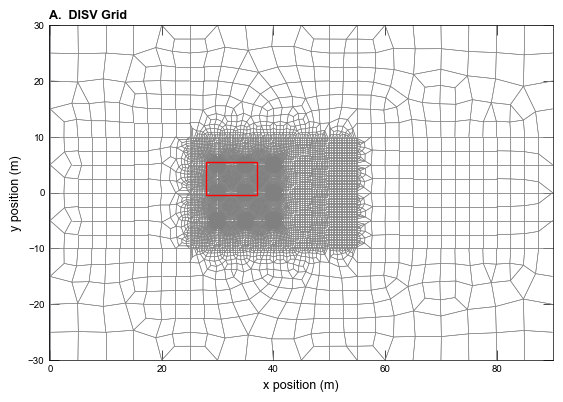

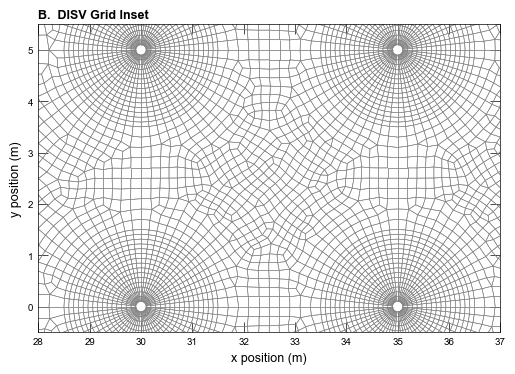

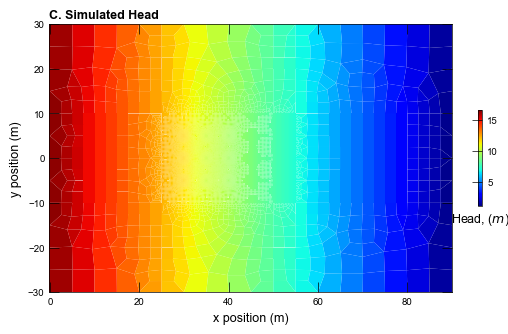

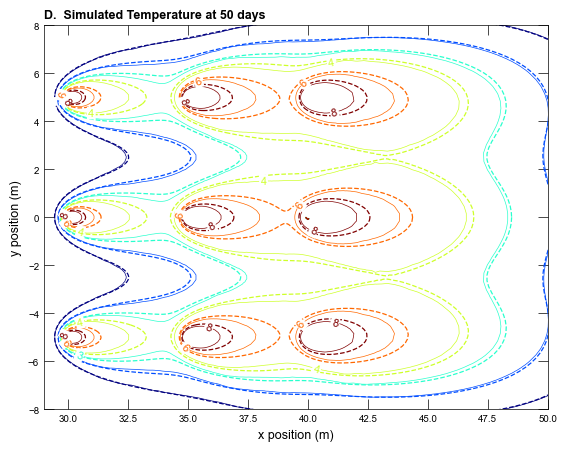

In [7]:
# Run the scenario
scenario(0)